# LOS Prediction - Feature Selection

This notebook performs LOS prediction on the 24 or 48 hour dataset after keeping only columns identified by feature selection. 

LOS prediction here is done using both linear regression and feedforward DNN.

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_boston
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

import numpy as np

print(tf.__version__)

Using TensorFlow backend.


2.0.0


(0, 200.0)

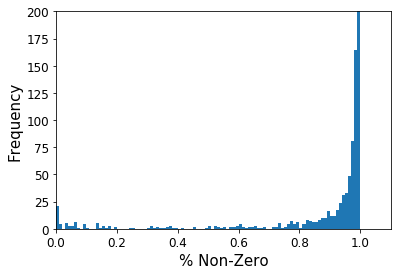

In [7]:

raw_dataset = pd.read_csv('../data/exp/pneumonia-t3/first48hours.csv', header=0)
df = raw_dataset.copy()

# Plot how many columns have non-zero values
(df==0).mean().hist(bins=100, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("% Non-Zero", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.xlim([0,1.1])
plt.ylim([0,200.0])



In [8]:

print("Num columns starting: " + str(len(df.columns)))

df = df.loc[:, (df==0).mean() < .9]
df.fillna(0, inplace=True)
df = df.replace([np.inf, -np.inf], 0)

# Remove rows where the chartevents aren't available
df = df[df['Heart Rate'] > 0]

# Shuffle data because data is ordered by admittime currently
df = df.sample(frac=1).reset_index(drop=True)
df.tail()


Num columns starting: 2474


,status,los,age,gender,insurance,language,religion,marital_status,ethnicity,Anion Gap,...,Systolic,Systolic-trend,O2 Flow.1,O2 Flow-trend.1,Respiratory Rate,Respiratory Rate-trend,Temperature.1,Temperature-trend.1,O2,O2-trend
3880,0,3.592,83.5884,M,Medicare,0,CATHOLIC,WIDOWED,WHITE,19.00,...,87.923,-0.107,12.0,-0.000,56.808,-0.225,36.772,-0.053,0.000,0.000
3881,0,13.810,62.5585,F,Medicare,ENGL,PROTESTANT QUAKER,MARRIED,BLACK/AFRICAN AMERICAN,16.50,...,145.125,0.325,11.1,0.194,22.939,-0.016,0.000,0.000,92.729,0.049
3882,1,10.144,75.3090,F,Medicare,0,JEWISH,WIDOWED,WHITE,14.75,...,114.107,-0.592,16.3,-0.681,60.810,-0.014,37.198,-0.047,0.000,0.000
3883,0,8.006,91.4000,M,Medicare,ENGL,UNOBTAINABLE,MARRIED,ASIAN - ASIAN INDIAN,12.00,...,143.267,-0.231,0.0,0.000,15.812,-0.037,0.000,0.000,99.917,0.010
3884,0,8.897,78.6739,M,Medicare,ENGL,OTHER,SINGLE,WHITE,14.00,...,0.000,0.000,0.0,0.000,59.368,5.404,0.000,0.000,0.000,0.000


In [54]:
# One hot encode the demographic columns
cols_to_one_hot = ['gender', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)
    #df = df.join(one_hot)
#df

In [55]:
los = df.pop('los')


In [77]:
from sklearn.linear_model import SGDClassifier, SGDRegressor, LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from math import sqrt


# NORMALIZE THE DATASET
stats = df.describe()
stats = stats.transpose()

def norm(x):
  return (x - stats['mean']) / stats['std']
normed_df = norm(df)

print("Num columns before feature selection: " + str(len(normed_df.columns)))

# RUN FEATURE SELECTION BASED ON SGD LINEAR REGRESSION
clf = SGDRegressor(loss="squared_loss", penalty="l1", eta0=0.0001)
sfm = SelectFromModel(clf, threshold=0.26) #0.19 = 72 features -> pretty good
sfm.fit(normed_df, los)
feature_idx = sfm.get_support()
transformed_df = normed_df.loc[:,feature_idx]
print("Num columns after feature selection: " + str(len(transformed_df.columns)))

# PRINT THE WEIGHT VECTOR
#coef = sfm.estimator_.coef_
#print(coef)

# DIVIDE INTO TRAIN/TEST
transformed_df.insert(0, 'los', los)
train_dataset = transformed_df.sample(frac=0.7,random_state=0)
test_dataset = transformed_df.drop(train_dataset.index)
train_labels = train_dataset.pop('los')
test_labels = test_dataset.pop('los')


X_train, X_val, y_train, y_val = train_test_split(train_dataset, train_labels, test_size=0.70)

# normed_train_data

clf = SGDRegressor(loss="squared_loss", penalty="l1", eta0=0.0001)
# clf = LinearRegression(normalize=True)
clf.fit(X_train, y_train)

y_train_preds = clf.predict(X_train)
training_error = mean_absolute_error(y_train, y_train_preds)
print("Training (LOS): " + str(training_error))

y_val_preds = clf.predict(X_val)
training_error = mean_absolute_error(y_val, y_val_preds)
print("Validation (LOS): " + str(training_error))

y_test_preds = clf.predict(test_dataset)
test_error = mean_absolute_error(test_labels, y_test_preds)
print("Testing (LOS): " + str(test_error))




# Selects features by their weights
#sfm = SelectFromModel(clf, threshold=0.25)
#sfm.fit(df, los)

#n_features = sfm.transform(X).shape[1]

# # Reset the threshold till the number of features equals two.
# # Note that the attribute can be set directly instead of repeatedly
# # fitting the metatransformer.
# while n_features > 2:
#     sfm.threshold += 0.1
#     X_transform = sfm.transform(X)
#     n_features = X_transform.shape[1]

# # Plot the selected two features from X.
# plt.title(
#     "Features selected from Boston using SelectFromModel with "
#     "threshold %0.3f." % sfm.threshold)
# feature1 = X_transform[:, 0]
# feature2 = X_transform[:, 1]
# plt.plot(feature1, feature2, 'r.')
# plt.xlabel("Feature number 1")
# plt.ylabel("Feature number 2")
# plt.ylim([np.min(feature2), np.max(feature2)])
# plt.show()

Num columns before feature selection: 223
Num columns after feature selection: 48
Training (LOS): 5.180234380155927
Validation (LOS): 5.955614035158934
Testing (LOS): 5.684135064173292



....................................................................................................

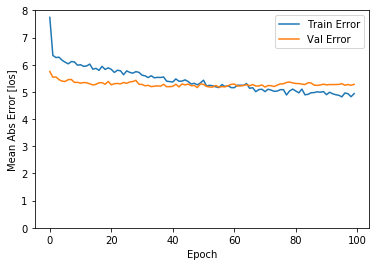

In [79]:
# column_weights = [(df.columns[i], coef[i]) for i in range(len(coef))]
# column_weights = sorted(column_weights, key=lambda tup: tup[1])
# len(column_weights)

### Try using the same data on a Neural Network

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
def build_model():
  model = keras.Sequential([
    layers.Dense(96, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dropout(0.5, name='dropout_1'),
    layers.Dense(96, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dropout(0.5, name='dropout_2'),
    layers.Dense(96, activation='relu', input_shape=[len(train_dataset.keys())]),
#     layers.Dense(512, kernel_initializer='normal',activation='relu'),
#     layers.Dropout(0.5, name='dropout_1'),
#     layers.Dense(512, kernel_initializer='normal',activation='relu'),
#     layers.Dropout(0.5, name='dropout_2'),
#     layers.Dense(512, kernel_initializer='normal',activation='relu'),
    layers.Dense(1)
  ])

#   optimizer = tf.keras.optimizers.RMSprop(0.001)
  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
example_batch = train_dataset[:3]
example_batch
example_result = model.predict(example_batch)
example_result

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [los]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,8])
  plt.legend()
  plt.show()


plot_history(history)

